In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.stats import pearsonr, false_discovery_control

from utils import get_expasy_peptide_mass, get_uniprotkbid

sns.set_theme(style="darkgrid")

# Load the data
Load the normalized data for the selected microdissociations

In [2]:
# load the counts data
counts = pd.read_csv("data/PDAC_MICRODISSEC_NAIF/rna_seq_selected_vst.csv", index_col=0)

# load the density data
densities = pd.read_csv("data/MALDI_IHC/microdissection_densities.csv", index_col=0)

In [3]:
# load the matirisom genes
matrisome_genes = pd.read_csv("Hs_Matrisome_Masterlist_2012.csv")

# load the gene annotation
gene_annotation = pd.read_csv("geneAnnot.tsv", sep="\t")

In [4]:
# load the immuno counts data frame
immuno_counts_density = pd.read_csv('data/MALDI_IHC/results/immuno_counts_density.csv')
immuno_counts_density.head()

,Microdissection,Slide,CD8_density,Collagen_density,Stroma_density,Tumor_density,Tcells,CD8Tcells,Cytotox.lymph,NK,B.lineage,Mono.lineage,Myeloid.dendritic,Neutrophils,Endothelial,Fibroblasts,Desert_CD8
0,BPDAC_023_19_L1_S92,12AG01290_19,0.014677,0.215176,0.365648,0.284161,6.672849,6.969208,6.256820,5.437879,7.219582,7.088289,6.225387,6.982800,7.020158,9.737424,False
1,BPDAC_023_26_L2_S13,12AG01290_26,0.001690,0.503843,0.440842,0.178647,5.116169,5.116169,5.116169,5.116169,5.116169,6.554249,5.116169,5.238039,5.116169,6.936181,False
2,X0823_013,12AG01290_26,0.003378,0.188455,0.528874,0.243212,5.961899,5.478708,5.965448,5.308200,6.767034,7.832972,5.455818,7.335261,6.473169,10.150876,False
3,BPDAC_029_26_L1_S70,13AG00043_26,0.000121,0.232225,0.401066,0.433123,5.359670,5.116169,5.323203,5.116169,6.089845,6.586788,6.280773,6.580186,6.007968,10.322599,False
4,X0923_009,13AG00043_26,0.000255,0.206276,0.533295,0.301814,5.726335,5.116169,5.571163,5.149485,6.024944,8.037350,5.914216,7.231064,6.860624,10.959386,False


## Add the gene id to the matrisome genes

In [5]:
# Define the Gene_Id column in the matrisome_genes dataframe
def get_gene_id(gene_symbol, gene_annotation):
    gene_id = gene_annotation[gene_annotation["GeneName"] == gene_symbol]["GeneID"].values
    return gene_id[0] if len(gene_id) > 0 else None

matrisome_genes["Gene_Id"] = matrisome_genes["Gene Symbol"].apply(lambda x: get_gene_id(x, gene_annotation))

## Clean the matrisome_genes dataframe

In [6]:
# Replace the " " by _ in the column names
matrisome_genes.columns = matrisome_genes.columns.str.replace(" ", "_")

# Clean the matrisome_genes unwanted columns
matrisome_genes = matrisome_genes.drop(columns=["Gene_Name", "Synonyms", "HGNC_IDs", "HGNC_IDs_Links", "UniProt_IDs", "Refseq_IDs", "Notes"])

# Rorder the columns
matrisome_genes = matrisome_genes[["Gene_Id", "Gene_Symbol", "Matrisome_Division", "Matrisome_Category"]]

# Remove the matrisome genes that are not in the counts data
matrisome_genes = matrisome_genes[matrisome_genes["Gene_Id"].isin(counts.index)]

## Clean densities dataframe

In [7]:
# Clean the desert samples with high CD8 T cell immuno counts
densities = densities.loc[immuno_counts_density[~immuno_counts_density["Desert_CD8"]]["Microdissection"]]

# Clean the defects
densities = densities[densities["Defects"] < 0.1]

# Exlude the microdissected samples out of lesion
densities = densities[densities["Lesion"] > 0.5]

# Drop the columns
densities = densities.drop(["Lesion", "Defects"], axis=1)

# Remove the densities that are not in the counts data
densities = densities[densities.index.isin(counts.columns)]

In [8]:
# Clean the counts to include only the genes in the matrisome_genes and the microdissections in the densities
counts = counts.loc[matrisome_genes.Gene_Id, densities.index]

In [9]:
# Compute the correlation between the counts and the densities
for density in densities.columns:
    correlations = []
    pvalues = []
    for gene in counts.index:
        corr, pvalu = pearsonr(counts.loc[gene], densities[density])
        correlations.append(corr)
        pvalues.append(pvalu)
        qvalues = false_discovery_control(ps=pvalues, method="bh")

    matrisome_genes[density] = correlations
    matrisome_genes[density + "_p"] = pvalues
    matrisome_genes[density + "_q"] = qvalues

matrisome_genes.head()

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
0,ENSG00000154175,ABI3BP,Core matrisome,ECM Glycoproteins,-0.146479,0.354628,0.995003,0.229184,0.144298,0.547660,-0.079733,0.615713,0.842989,-0.000224,0.998878,0.998878
1,ENSG00000181092,ADIPOQ,Core matrisome,ECM Glycoproteins,0.180495,0.252680,0.995003,0.201660,0.200310,0.649019,-0.046391,0.770490,0.929576,0.100713,0.525681,0.797316
2,ENSG00000106624,AEBP1,Core matrisome,ECM Glycoproteins,0.026378,0.868299,0.995003,0.085676,0.589555,0.886381,0.432839,0.004196,0.049625,-0.434624,0.004026,0.043798
3,ENSG00000188157,AGRN,Core matrisome,ECM Glycoproteins,-0.217187,0.167091,0.995003,-0.280045,0.072453,0.471421,-0.280384,0.072094,0.272354,0.324672,0.035921,0.167367
7,ENSG00000242252,BGLAP,Core matrisome,ECM Glycoproteins,0.009915,0.950310,0.995003,-0.207867,0.186514,0.635546,-0.122799,0.438489,0.760086,0.038703,0.807738,0.946531


In [10]:
# Exclude the pvalues and qvalues columns
corr_genes = matrisome_genes.drop(columns=[col for col in matrisome_genes.columns if "_p" in col] + [col for col in matrisome_genes.columns if "_q" in col])

# Melt the data to have the Staining as a column
corr_staining = corr_genes.melt(id_vars=["Gene_Id", "Matrisome_Division", "Matrisome_Category", "Gene_Symbol"],
                                var_name="Staining",
                                value_name="Correlation")

# Filter the data to have only the Tumor and Stroma staining
corr_tumor_stroma = corr_staining[corr_staining["Staining"].isin(["Tumor", "Stroma"])]

# Melt the data to have the Matrisome Division as a column
corr_division = corr_genes.melt(id_vars=["Gene_Id", "Matrisome_Category", "Gene_Symbol", "CD8", "Collagen", "Stroma", "Tumor"],
                                var_name="Matrisome_Division",
                                value_name="Division")

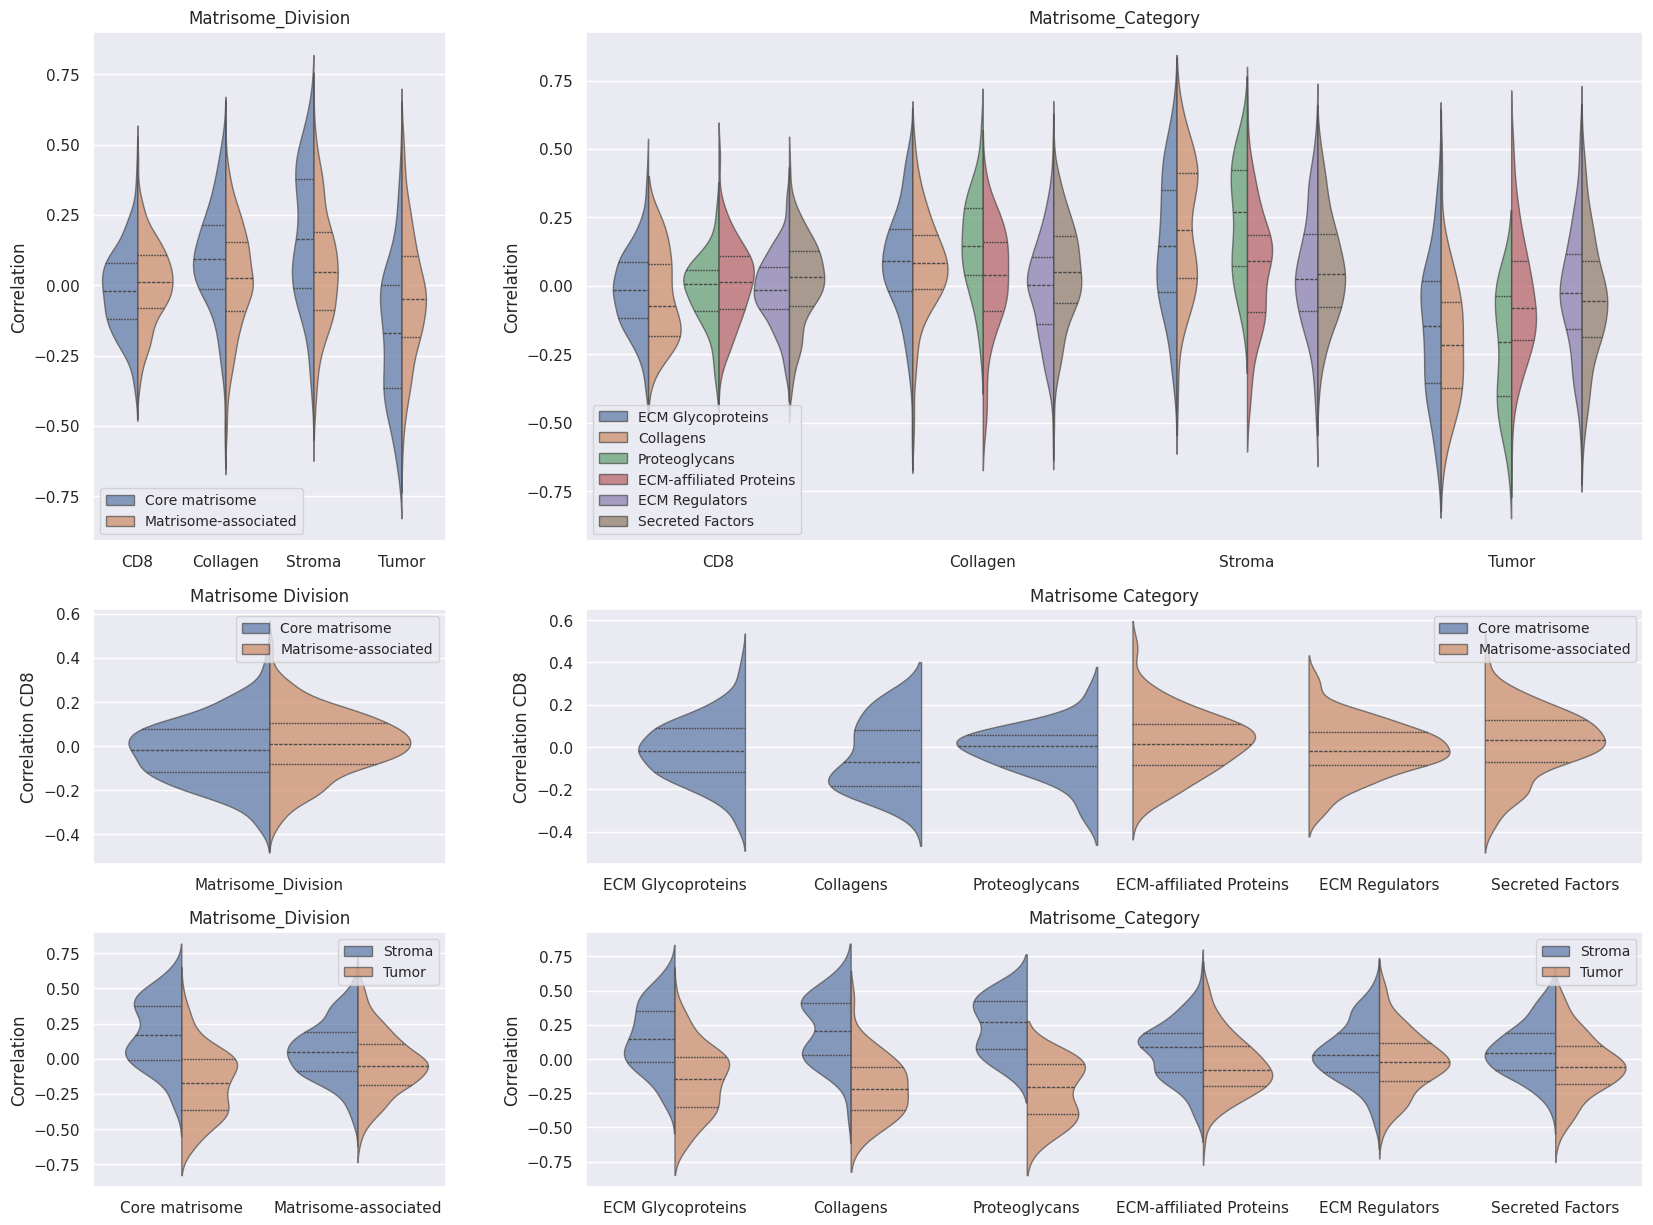

In [11]:
# Draw a violin plot of the correlation values for each Matrisome Division and Matrisome Category
fig, ax = plt.subplots(3, 2, figsize=(20, 15), gridspec_kw={'width_ratios': [1, 3], 'height_ratios': [2, 1, 1]})
sns.violinplot(x="Staining", y="Correlation", data=corr_staining, hue="Matrisome_Division", ax=ax[0, 0], alpha=0.7, split=True, inner="quart", linewidth=1)
ax[0, 0].set_title("Matrisome_Division")
ax[0, 0].set_xlabel("")
ax[0, 0].set_ylabel("Correlation")
ax[0, 0].tick_params(axis='x')
ax[0, 0].legend(loc='lower left', fontsize='small')

sns.violinplot(x="Staining", y="Correlation", data=corr_staining, hue="Matrisome_Category", ax=ax[0, 1], alpha=0.7, split=True, inner="quart", linewidth=1)
ax[0, 1].set_title("Matrisome_Category")
ax[0, 1].set_xlabel("")
ax[0, 1].set_ylabel("Correlation")
ax[0, 1].tick_params(axis='x')
ax[0, 1].legend(loc='lower left', fontsize='small')

sns.violinplot(x="Matrisome_Division", y="CD8", data=corr_division, ax=ax[1, 0], alpha=0.7, hue="Division", split=True, inner="quart", linewidth=1)
ax[1, 0].set_title("Matrisome Division")
ax[1, 0].set_xlabel("")
ax[1, 0].set_ylabel("Correlation CD8")
ax[1, 0].tick_params(axis='x')
ax[1, 0].legend(loc='upper right', fontsize='small')

sns.violinplot(x="Matrisome_Category", y="CD8", data=corr_division, ax=ax[1, 1], alpha=0.7, hue="Division", split=True, inner="quart", linewidth=1)
ax[1, 1].set_title("Matrisome Category")
ax[1, 1].set_xlabel("")
ax[1, 1].set_ylabel("Correlation CD8")
ax[1, 1].tick_params(axis='x')
ax[1, 1].legend(loc='upper right', fontsize='small')

sns.violinplot(x="Matrisome_Division", y="Correlation", data=corr_tumor_stroma, hue="Staining", ax=ax[2, 0], alpha=0.7, split=True, inner="quart", linewidth=1)
ax[2, 0].set_title("Matrisome_Division")
ax[2, 0].set_xlabel("")
ax[2, 0].set_ylabel("Correlation")
ax[2, 0].tick_params(axis='x')
ax[2, 0].legend(loc='upper right', fontsize='small')

sns.violinplot(x="Matrisome_Category", y="Correlation", data=corr_tumor_stroma, hue="Staining", ax=ax[2, 1], alpha=0.7, split=True, inner="quart", linewidth=1)
ax[2, 1].set_title("Matrisome_Category")
ax[2, 1].set_xlabel("")
ax[2, 1].set_ylabel("Correlation")
ax[2, 1].tick_params(axis='x')
ax[2, 1].legend(loc='upper right', fontsize='small')

plt.show()

# Find the highest correlated and anti-correlated genes with CD8

In [12]:
# Find the top genes with the highest correlation with CD8
top_genes = matrisome_genes.nlargest(20, 'CD8')
top_genes

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
303,ENSG00000090659,CD209,Matrisome-associated,ECM-affiliated Proteins,0.485934,0.001105,0.692452,0.118637,0.454278,0.835139,0.195284,0.215209,0.547074,-0.196898,0.211367,0.508777
341,ENSG00000164035,EMCN,Matrisome-associated,ECM-affiliated Proteins,0.454146,0.002519,0.692452,0.253972,0.104591,0.505416,0.137420,0.385484,0.734693,-0.250509,0.109572,0.339964
994,ENSG00000106952,TNFSF8,Matrisome-associated,Secreted Factors,0.440248,0.003527,0.692452,0.088865,0.575725,0.881910,0.025819,0.871067,0.961828,0.010087,0.949448,0.994034
719,ENSG00000276409,CCL14,Matrisome-associated,Secreted Factors,0.433826,0.004101,0.692452,0.293713,0.059038,0.458811,0.263347,0.091975,0.326312,-0.224627,0.152668,0.420869
91,ENSG00000153902,LGI4,Core matrisome,ECM Glycoproteins,0.432361,0.004243,0.692452,0.010975,0.945002,0.994252,-0.012084,0.939459,0.974821,-0.011834,0.940706,0.994034
765,ENSG00000107562,CXCL12,Matrisome-associated,Secreted Factors,0.365963,0.017150,0.995003,0.357668,0.020044,0.286949,0.387181,0.011304,0.087848,-0.511523,0.000536,0.012858
136,ENSG00000169218,RSPO1,Core matrisome,ECM Glycoproteins,0.363688,0.017906,0.995003,0.283384,0.068973,0.462273,0.171551,0.277344,0.610298,-0.137326,0.385814,0.691371
560,ENSG00000055957,ITIH1,Matrisome-associated,ECM Regulators,0.343549,0.025911,0.995003,0.032417,0.838508,0.994252,0.054761,0.730517,0.902454,-0.218412,0.164651,0.440463
135,ENSG00000189056,RELN,Core matrisome,ECM Glycoproteins,0.337683,0.028736,0.995003,0.308296,0.046992,0.395318,0.228686,0.145196,0.438839,-0.334615,0.030313,0.147748
681,ENSG00000095587,TLL2,Matrisome-associated,ECM Regulators,0.332144,0.031634,0.995003,0.074664,0.638402,0.912322,0.147552,0.351077,0.700177,-0.167347,0.289466,0.582838


In [13]:
# Find the top genes with the lowest correlation with CD8
bottom_genes = matrisome_genes.nsmallest(20, 'CD8')
bottom_genes

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
997,ENSG00000112715,VEGFA,Matrisome-associated,Secreted Factors,-0.392945,0.010047,0.995003,-0.092620,0.559634,0.881238,-0.183841,0.243843,0.584528,0.226630,0.148948,0.414816
75,ENSG00000135253,KCP,Core matrisome,ECM Glycoproteins,-0.384671,0.011892,0.995003,0.021104,0.894466,0.994252,-0.041455,0.794351,0.937146,-0.012198,0.938887,0.994034
871,ENSG00000150782,IL18,Matrisome-associated,Secreted Factors,-0.376277,0.014051,0.995003,-0.197081,0.210935,0.650832,-0.040616,0.798425,0.938782,0.135613,0.391822,0.695058
885,ENSG00000110944,IL23A,Matrisome-associated,Secreted Factors,-0.371514,0.015417,0.995003,-0.036420,0.818881,0.994252,0.080349,0.612978,0.840893,-0.039366,0.804507,0.946531
83,ENSG00000196878,LAMB3,Core matrisome,ECM Glycoproteins,-0.366137,0.017093,0.995003,-0.139991,0.376571,0.779903,-0.212148,0.177402,0.497525,0.350894,0.022702,0.128732
761,ENSG00000006210,CX3CL1,Matrisome-associated,Secreted Factors,-0.360967,0.018848,0.995003,0.288265,0.064125,0.462273,0.026259,0.868887,0.961828,-0.013563,0.932064,0.994034
86,ENSG00000058085,LAMC2,Core matrisome,ECM Glycoproteins,-0.345405,0.025066,0.995003,-0.199405,0.205494,0.649019,-0.177254,0.261441,0.604778,0.319012,0.039476,0.176025
99,ENSG00000132031,MATN3,Core matrisome,ECM Glycoproteins,-0.341018,0.027100,0.995003,0.337085,0.029039,0.310145,0.349736,0.023185,0.126972,-0.312543,0.043886,0.185548
247,ENSG00000164283,ESM1,Core matrisome,Proteoglycans,-0.337021,0.029071,0.995003,0.021048,0.894743,0.994252,0.019148,0.904199,0.967753,0.064214,0.686204,0.885413
661,ENSG00000149257,SERPINH1,Matrisome-associated,ECM Regulators,-0.331727,0.031862,0.995003,-0.082806,0.602127,0.886381,0.198184,0.208341,0.537917,-0.150593,0.341124,0.636975


# Clean the genes
* Foucs on the core matrisome genes
* Remove the low correlated genes with the stroma
* Remove the high correlated genes with the tumor cells

In [14]:
# Remove the secreted factors
df_clean = matrisome_genes[matrisome_genes.Matrisome_Division != "Matrisome-associated"]

# Remove the highly correlated genes with the stroma
df_clean = df_clean[df_clean.Stroma > 0]

# Remove the highly correlated genes with the tumor
df_clean = df_clean[df_clean.Tumor < 0]

In [15]:
# Find the top genes with the highest correlation with CD8
top_genes = df_clean.nlargest(20, 'CD8')
top_genes

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
136,ENSG00000169218,RSPO1,Core matrisome,ECM Glycoproteins,0.363688,0.017906,0.995003,0.283384,0.068973,0.462273,0.171551,0.277344,0.610298,-0.137326,0.385814,0.691371
135,ENSG00000189056,RELN,Core matrisome,ECM Glycoproteins,0.337683,0.028736,0.995003,0.308296,0.046992,0.395318,0.228686,0.145196,0.438839,-0.334615,0.030313,0.147748
138,ENSG00000146374,RSPO3,Core matrisome,ECM Glycoproteins,0.266044,0.088573,0.995003,0.269164,0.084760,0.482230,0.383343,0.012213,0.091862,-0.350857,0.022717,0.128732
239,ENSG00000157766,ACAN,Core matrisome,Proteoglycans,0.254762,0.103480,0.995003,0.169141,0.284252,0.720340,0.292475,0.060165,0.238128,-0.390254,0.010618,0.077362
212,ENSG00000171502,COL24A1,Core matrisome,Collagens,0.250568,0.109486,0.995003,0.068713,0.665463,0.929462,0.365513,0.017298,0.112025,-0.344353,0.025542,0.135341
201,ENSG00000204291,COL15A1,Core matrisome,Collagens,0.248574,0.112432,0.995003,0.390287,0.010611,0.222017,0.620137,0.000012,0.001902,-0.546478,0.000181,0.006715
217,ENSG00000139219,COL2A1,Core matrisome,Collagens,0.230972,0.141107,0.995003,0.243773,0.119773,0.520436,0.455237,0.002452,0.036375,-0.448581,0.002887,0.036067
170,ENSG00000168477,TNXB,Core matrisome,ECM Glycoproteins,0.223502,0.154790,0.995003,0.426067,0.004903,0.160018,0.337940,0.028607,0.143212,-0.405802,0.007668,0.067301
41,ENSG00000188107,EYS,Core matrisome,ECM Glycoproteins,0.221975,0.157701,0.995003,-0.011819,0.940780,0.994252,0.067067,0.673021,0.871644,-0.065843,0.678665,0.881848
156,ENSG00000109927,TECTA,Core matrisome,ECM Glycoproteins,0.213693,0.174193,0.995003,0.279726,0.072793,0.471421,0.163065,0.302159,0.638356,-0.186881,0.235997,0.534855


In [16]:
# Find the top genes with the lowest correlation with CD8
bottom_genes = df_clean.nsmallest(20, 'CD8')
bottom_genes

,Gene_Id,Gene_Symbol,Matrisome_Division,Matrisome_Category,CD8,CD8_p,CD8_q,Collagen,Collagen_p,Collagen_q,Stroma,Stroma_p,Stroma_q,Tumor,Tumor_p,Tumor_q
99,ENSG00000132031,MATN3,Core matrisome,ECM Glycoproteins,-0.341018,0.027100,0.995003,0.337085,0.029039,0.310145,0.349736,0.023185,0.126972,-0.312543,0.043886,0.185548
210,ENSG00000169436,COL22A1,Core matrisome,Collagens,-0.315148,0.042064,0.995003,0.199760,0.204673,0.649019,0.293168,0.059532,0.238128,-0.284165,0.068179,0.248366
102,ENSG00000140259,MFAP1,Core matrisome,ECM Glycoproteins,-0.275409,0.077512,0.995003,0.001037,0.994801,0.998547,0.027713,0.861696,0.960579,-0.012964,0.935058,0.994034
273,ENSG00000038427,VCAN,Core matrisome,Proteoglycans,-0.270781,0.082835,0.995003,0.250469,0.109631,0.505416,0.485307,0.001124,0.022361,-0.430215,0.004459,0.046053
61,ENSG00000143341,HMCN1,Core matrisome,ECM Glycoproteins,-0.267278,0.087049,0.995003,0.362180,0.018423,0.273429,0.637244,0.000006,0.001223,-0.637493,0.000006,0.000813
132,ENSG00000133110,POSTN,Core matrisome,ECM Glycoproteins,-0.263546,0.091721,0.995003,0.029750,0.851641,0.994252,0.337539,0.028809,0.143342,-0.180224,0.253404,0.544152
149,ENSG00000262655,SPON1,Core matrisome,ECM Glycoproteins,-0.253396,0.105408,0.995003,0.120153,0.448492,0.827985,0.440094,0.003540,0.044435,-0.379663,0.013143,0.088631
219,ENSG00000187498,COL4A1,Core matrisome,Collagens,-0.252394,0.106839,0.995003,0.244224,0.119069,0.520436,0.362249,0.018399,0.114608,-0.219467,0.162571,0.436375
218,ENSG00000168542,COL3A1,Core matrisome,Collagens,-0.247945,0.113373,0.995003,0.083669,0.598334,0.886381,0.486186,0.001097,0.022361,-0.454524,0.002495,0.033854
69,ENSG00000115461,IGFBP5,Core matrisome,ECM Glycoproteins,-0.221503,0.158609,0.995003,0.248240,0.112932,0.517711,0.234193,0.135493,0.418797,-0.204450,0.194023,0.485653


# Get the peptide mass
Get a UniProtKB list of protein ids for each gene then get the peptide masses for each protein using ExPASy peptide mass tool.

In [ ]:
# Peptides mass path
peptides_mass_path = "data/MALDI_IHC/results/peptides_mass_ihc"

# Create the directory if it does not exist
os.makedirs(peptides_mass_path, exist_ok=True)

# Get the gene names for the top and bottom genes and remove duplicates
genes = pd.concat([top_genes, bottom_genes])['Gene_Symbol'].unique()

# Get the peptide mass for each gene
for gene in genes:
    print(f"\nGene: {gene}")

    # Get a list of protein names for the gene
    protein_names = get_uniprotkbid(gene)
    
    # Get the peptide mass for each protein name
    for protein_name in protein_names:
        print(f"Protein: {protein_name}")

        # Check if the file already exists
        if not os.path.exists(f"{peptides_mass_path}/{protein_name}_peptide_mass.csv"):

            # Get the peptide mass
            peptide_mass = get_expasy_peptide_mass(protein_name)
            print(f"{peptide_mass.shape[0]} peptides")

            # Save the peptide mass to a csv file
            peptide_mass.to_csv(f"{peptides_mass_path}/{protein_name}_peptide_mass.csv", index=False)


Gene: RELN
Protein: RELN_HUMAN
154 peptides

Gene: ACAN
Protein: PGCA_HUMAN
54 peptides

Gene: COL15A1
Protein: COFA1_HUMAN
48 peptides

Gene: VWF
Protein: VWF_HUMAN
44 peptides

Gene: RSPO3
Protein: RSPO3_HUMAN
18 peptides

Gene: TNXB
Protein: TENX_HUMAN
215 peptides

Gene: MFAP3
Protein: MFAP3_HUMAN
24 peptides

Gene: COL26A1
Protein: COQA1_HUMAN
25 peptides

Gene: COL24A1
Protein: COOA1_HUMAN
103 peptides

Gene: MATN4
Protein: MATN4_HUMAN
40 peptides

Gene: SBSPON
Protein: SBSPO_HUMAN
15 peptides

Gene: COL19A1
Protein: COJA1_HUMAN
71 peptides

Gene: RSPO1
Protein: RSPO1_HUMAN
15 peptides

Gene: ELSPBP1
Protein: ESPB1_HUMAN
15 peptides

Gene: FBLN5
Protein: FBLN5_HUMAN
23 peptides

Gene: PRG2
Protein: PRG2_HUMAN
6 peptides
Protein: PXDN_HUMAN
91 peptides
Protein: PLPR3_HUMAN
37 peptides

Gene: COL28A1
Protein: COSA1_HUMAN
81 peptides

Gene: CRISPLD2
Protein: CRLD2_HUMAN
30 peptides

Gene: VWA3B
Protein: VWA3B_HUMAN
103 peptides

Gene: EYS
Protein: EYS_HUMAN
163 peptides

Gene: MATN

# Make a reference of the correlated peptides mass

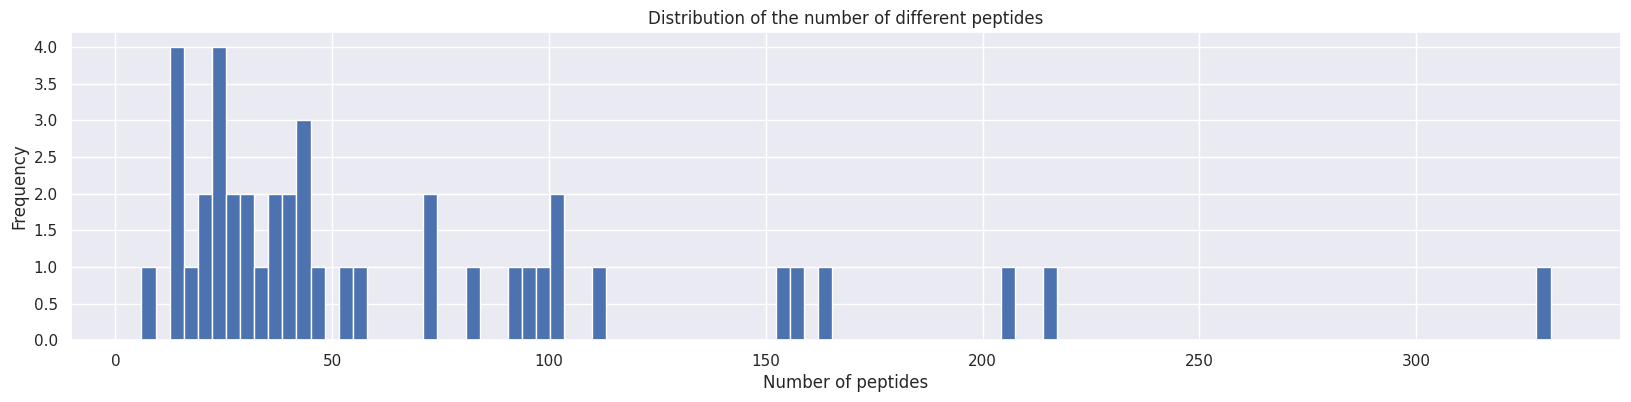

Number of proteins: 42
Number of proteins with less than 100 peptides: 33
Number of proteins with more than 100 peptides: 9


In [18]:
# Extract the protein peptide masses
masses = [pd.read_csv(f"{peptides_mass_path}/{protein}")["mass"] for protein in os.listdir(peptides_mass_path)]

masses_number = [len(mass) for mass in masses]

# Plot the distribution of the peptide masses number
plt.figure(figsize=(20, 4))
plt.hist(masses_number, bins=100)
plt.xlabel("Number of peptides")
plt.ylabel("Frequency")
plt.title("Distribution of the number of different peptides")
plt.show()

print(f"Number of proteins: {len(masses)}")
print(f"Number of proteins with less than 100 peptides: {sum([1 for mass in masses_number if mass < 100])}")
print(f"Number of proteins with more than 100 peptides: {sum([1 for mass in masses_number if mass > 100])}")

In [19]:
# # pool the peptide masses of all the proteins with number of peptides < 100
# masses_pool = np.concatenate([mass for mass in masses if len(mass) < 100])

# pool the peptide masses of all the proteins
masses_pool = np.concatenate(masses)

# Sort the masses pool
masses_pool = np.sort(masses_pool)

# Build a reference of unique masses
unique_masses = np.unique(masses_pool)

print(f"Number of unique masses: {unique_masses.shape[0]}")
print(f"Number of duplicated masses: {masses_pool.shape[0] - unique_masses.shape[0]}")

Number of unique masses: 2731
Number of duplicated masses: 132


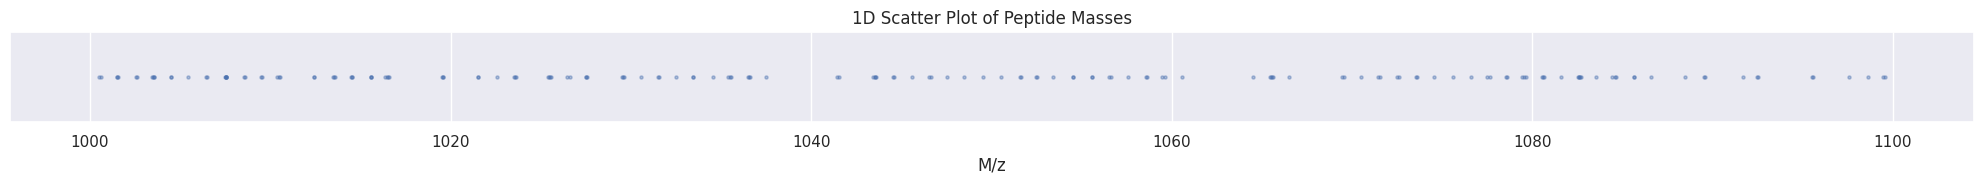

In [20]:
# Sample array of masses
masses_sample = masses_pool[(masses_pool > 1000) & (masses_pool < 1100)] 

plt.figure(figsize=(20, 2), tight_layout=True)
plt.scatter(masses_sample, [0]*len(masses_sample), s=5, alpha=0.4)
plt.xlabel("M/z")
plt.title("1D Scatter Plot of Peptide Masses")
plt.yticks([])
plt.show()

In [ ]:
# Save the unique masses to a csv file
pd.DataFrame(unique_masses, columns=["mass"]).to_csv("data/MALDI_IHC/results/correlated_masses_reference_ihc.csv", index=False)